In [20]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.svm import SVR, SVC


Now it's time for another guided example. This time we're going to look at recipes. Specifically we'll use the epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

What we want to see is if we can use the ingredient and keyword list to predict the rating. For someone writing a cookbook this could be really useful information that could help them choose which recipes to include because they're more likely to be enjoyed and therefore make the book more likely to be successful.

First let's load the dataset. It's [available on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes). We'll use the csv file here and as pull out column names and some summary statistics for ratings.

In [2]:
raw_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')

In [3]:
len(list(raw_data.columns))

680

In [4]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

We learn a few things from this analysis. From a ratings perspective, there are just over 20,000 recipes with an average rating of 3.71. What is interesting is that the 25th percentile is actually above the mean. This means there is likely some kind of outlier population. This makes sense when we think about reviews: some bad recipes may have very few very low reviews.

Let's validate the idea a bit further with a histogram.

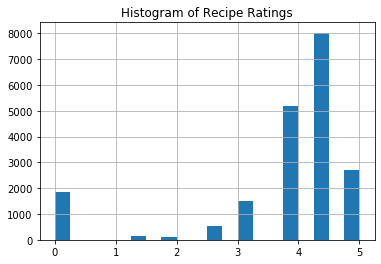

In [5]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

So a few things are shown in this histogram. Firstly there are sharp discontinutities. We don't have continuous data. No recipe has a 3.5 rating, for example. Also we see the anticipated increase at 0.

Let's try a naive approach again, this time using SVM Regressor. But first, we'll have to do a bit of data cleaning.

In [6]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

What we can see right away is that nutrition information is not available for all goods. Now this would be an interesting data point, but let's focus on ingredients and keywords right now. So we'll actually drop the whole columns for calories, protein, fat, and sodium. We'll come back to nutrition information later.

In [7]:
svr = SVR()
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.3, replace=True, random_state=1)
Y = raw_data.rating.sample(frac=0.3, replace=True, random_state=1)
svr.fit(X,Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

__Note that this actually takes quite a while to run, compared to some of the models we've done before. Be patient.__ It's because of the number of features we have.

Let's see what a scatter plot looks like, comparing actuals to predicted.

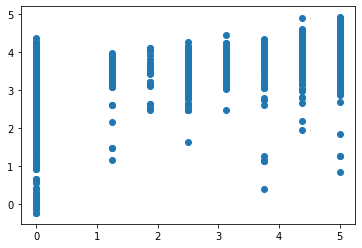

In [8]:
plt.scatter(Y, svr.predict(X))

Now that is a pretty useless visualization. This is because of the discontinuous nature of our outcome variable. There's too much data for us to really see what's going on here. If you wanted to look at it you could create histograms, here we'll move on to the scores of both our full fit model and with cross validation. Again if you choose to run it again it will take some time, so you probably shouldn't.

In [9]:
svr.score(X, Y)

0.4099845913800794

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(svr, X, Y, cv=5)

array([0.19563385, 0.14683481, 0.15013401, 0.13597791, 0.16082192])

Oh dear, so this did seem not to work very well. In fact it is remarkably poor. Now there are many things that we could do here. 

Firstly the overfit is a problem, even though it was poor in the first place. We could go back and clean up our feature set. There might be some gains to be made by getting rid of the noise.

We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

Lastly, we could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.

__And that is your challenge.__

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

Good luck!

When you've finished that, also take a moment to think about bias. Is there anything in this dataset that makes you think it could be biased, perhaps extremely so?

There is. Several things in fact, but most glaringly is that we don't actually have a random sample. It could be, and probably is, that the people more likely to choose some kinds of recipes are more likely to give high reviews.

After all, people who eat chocolate _might_ just be happier people.

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

In [4]:
import warnings
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
def print_vif(x, get_vifs=False):
    

    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

    if get_vifs == True:
        return vifs

In [5]:
raw_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')

In [6]:
raw_data = raw_data.dropna()
raw_data.isna().sum()

title         0
rating        0
calories      0
protein       0
fat           0
             ..
cookbooks     0
leftovers     0
snack         0
snack week    0
turkey        0
Length: 680, dtype: int64

In [7]:
hi_ratings = raw_data['rating'] > 3.5
raw_data['rating_level'] = hi_ratings

raw_data.head()
raw_data['rating_level'] = raw_data["rating_level"].astype(int)
raw_data = raw_data.dropna()
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15864 entries, 0 to 20051
Columns: 681 entries, title to rating_level
dtypes: float64(679), int32(1), object(1)
memory usage: 82.5+ MB


In [8]:
X = raw_data.drop(columns=['rating', 'title', 'rating_level'])
y = raw_data['rating_level']

feature_names = list(X.columns.values)



In [9]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2

selector = SelectKBest(k=30).fit(X, y)
X_best = selector.transform(X)

# pipeline = Pipeline([
#     ('feature_selection', SelectFromModel(ExtraTreesClassifier)),
#     ('classification', SVR())
    
# ])
# pipeline.fit(X_train, y_train)

C:\Users\dgump\miniconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 97 199 225 229 247 292 298 323 385 401 528 647] are constant.
  UserWarning)
C:\Users\dgump\miniconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [10]:
mask = selector.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)
        
X_best = pd.DataFrame(X_best, columns=new_features)


In [11]:
X_best.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15864 entries, 0 to 15863
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   alcoholic       15864 non-null  float64
 1   bake            15864 non-null  float64
 2   bitters         15864 non-null  float64
 3   bon appétit     15864 non-null  float64
 4   cocktail        15864 non-null  float64
 5   cocktail party  15864 non-null  float64
 6   condiment       15864 non-null  float64
 7   créme de cacao  15864 non-null  float64
 8   drink           15864 non-null  float64
 9   fall            15864 non-null  float64
 10  fortified wine  15864 non-null  float64
 11  fruit juice     15864 non-null  float64
 12  gin             15864 non-null  float64
 13  harpercollins   15864 non-null  float64
 14  house & garden  15864 non-null  float64
 15  liqueur         15864 non-null  float64
 16  low carb        15864 non-null  float64
 17  non-alcoholic   15864 non-null 

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size = 0.2, stratify = y)

In [30]:
grid = {
    "svc__kernel": ['rbf', 'linear'],
    #"svc__epsilon": [0.01,0.1,1,10,100,1000],
    "svc__C": [0.01,0.1,1,10,100,1000],
}

n_trees = 100
learning_rate = 2 / n_trees

# fmt: off
pipeline = Pipeline([
    #("preprocessing", preprocessing),
    ("svc", SVC()),
])
# fmt: on

pipeline_cv = GridSearchCV(pipeline, grid, verbose=1, cv=2, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

pipeline_cv.best_params_

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   15.6s finished


{'svc__C': 1, 'svc__kernel': 'rbf'}

In [31]:
pipeline_cv.score(X_train, y_train)

0.8231817823654558

In [32]:
pipeline_cv.score(X_test, y_test)

0.8134257800189095

In [33]:
y_pred = pipeline_cv.predict(X_test)

In [34]:
from sklearn.metrics import classification_report

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.08      0.14       614
           1       0.82      0.99      0.90      2559

    accuracy                           0.81      3173
   macro avg       0.73      0.53      0.52      3173
weighted avg       0.78      0.81      0.75      3173



In [36]:
y_prob = pipeline_cv.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], c="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC is {auc:.4f})")
plt.show()

AttributeError: predict_proba is not available when  probability=False